In [47]:
import numpy as np
from scipy import sparse
from scipy import optimize as op
from scipy.stats import norm
time_series_a = np.loadtxt('time_series_a.txt')
time_series_b = np.loadtxt('time_series_b.txt')
time_series_c = np.loadtxt('time_series_c.txt')

from matplotlib import pyplot as plt
%matplotlib inline

# ARMA model fitting

In [102]:
def arma_likelihood(time_series, phis=np.array([]), thetas=np.array([]), mu=0, sigma=1):
    """
    Return the log-likelihood of the ARMA model parameters, given the time
    series.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
    The time series in question, z_t
    phis : ndarray of shape (p,)
    The phi parameters
    thetas : ndarray of shape (q,)
    The theta parameters
    mu : float
    The parameter mu
    sigma : float
    The standard deviation of the a_t random variables
    Returns
    -------
    log_likelihood : float
    The log-likelihood of the model
    """
    p = len(phis)
    q = len(thetas)
    r = max(p, q+1)
    z = time_series
    
    F = np.diag(np.ones(r-1), -1)
    F[0,:len(phis)] = phis
    
    H = np.zeros(r)
    H[0] = 1
    H[1:len(thetas) + 1] = thetas
    
    Q = np.zeros((r,r))
    Q[0, 0] = sigma ** 2
    
    guess = np.zeros(r)
    Pg = np.linalg.inv(np.eye(r**2) - np.kron(F, F)).dot(Q.flatten()).reshape((r,r))
    
    zs = []
    xs = []
    Ps = []
    
    likelihood = 0
    
    for j in range(len(z)):

        if j > 0:
            guess = F.dot(x)
            Pg = F.dot(P).dot(F.T) + Q
            
        y = z[j] - mu - H.dot(guess)
        S = H.dot(Pg).dot(H.T)
        K = Pg.dot(H.T) / S
        x = guess + K * y
        P = (np.eye(r)-np.outer(K,H)).dot(Pg)
        xs.append(guess)
        Ps.append(Pg)
        
        
        std = np.abs(H.dot(Pg).dot(H.T))
        likelihood += np.log(norm.pdf(z[j], loc=H.dot(guess) + mu, scale=np.sqrt(std)))
        
    return likelihood, xs[-1], Ps[-1]

In [58]:
print arma_likelihood(time_series_a, phis=np.array([0.9]), mu=17., sigma=0.4)[0]

-77.6035449655


In [84]:
def arma_fit(time_series):
    """
    Return the ARMA model that minimizes AICc for the given time series,
    subject to p,q <= 3.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
        The time series in question, z_t
    Returns
    -------
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    """
    aics = []
    n = len(time_series)
    for p in range(4):
        for q in range(4):
            print p, q
            def f(x):
                return -1 * arma_likelihood(time_series, phis=x[:p], thetas=x[p:p+q], mu=x[-2],sigma=x[-1])[0]
            # create initial point
            k = p + q + 2
            x0 = np.zeros(k)
            x0[-2] = time_series.mean()
            x0[-1] = time_series.std()
            sol = op.fmin(f,x0,maxiter=10000, maxfun=10000)
#             print sol
            aic = 2 * k * (1 + (k + 1.) / (n - k)) + 2 * f(sol)
#             print aic
            aics.append((aic, sol[:p], sol[p:p+q], sol[-2], sol[-1]))
        
    return min(aics, key = lambda x: x[0])[1:]

In [85]:
parama = arma_fit(time_series_a)
print "A: ", parama, len(parama[0]), len(parama[1])
paramb = arma_fit(time_series_b)
print "B :", paramb, len(paramb[0]), len(paramb[1])
paramc = arma_fit(time_series_c)
print "C: ", paramc, len(paramc[0]), len(paramc[1])

0 0
Optimization terminated successfully.
         Current function value: 98.149109
         Iterations: 22
         Function evaluations: 45
0 1
Optimization terminated successfully.
         Current function value: 75.074473
         Iterations: 84
         Function evaluations: 150
0 2
Optimization terminated successfully.
         Current function value: 63.797437
         Iterations: 149
         Function evaluations: 255
0 3
Optimization terminated successfully.
         Current function value: 58.776606
         Iterations: 343
         Function evaluations: 547
1 0
Optimization terminated successfully.
         Current function value: 59.438386
         Iterations: 89
         Function evaluations: 162
1 1
Optimization terminated successfully.
         Current function value: 50.745092
         Iterations: 202
         Function evaluations: 340
1 2
Optimization terminated successfully.
         Current function value: 50.045019
         Iterations: 561
         Function evalua

In [109]:
def arma_forecast(time_series, phis=np.array([]), thetas=np.array([]), mu=0., sigma=1., future_periods=20):
    """
    Return forecasts for a time series modeled with the given ARMA model.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
        The time series in question, z_t
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    future_periods : int
        The number of future periods to return
    Returns
    -------
    e_vals : ndarray of shape (future_periods,)
        The expected values of z for times n+1, ..., n+future_periods
    sigs : ndarray of shape (future_periods,)
        The standard deviations of z for times n+1, ..., n+future_periods
    """
    p = len(phis)
    q = len(thetas)
    r = max(p, q+1)
    
    F = np.diag(np.ones(r-1), -1)
    F[0,:len(phis)] = phis
    
    H = np.zeros(r)
    H[0] = 1
    H[1:len(thetas) + 1] = thetas
    
    Q = np.zeros((r,r))
    Q[0, 0] = sigma ** 2
    
    x = np.zeros(r)
    P = np.linalg.inv(np.eye(r**2) - np.kron(F, F)).dot(Q.flatten())
    
    # Recurse x and P up to current time, before predicting next.
    l, x, P = arma_likelihood(time_series, phis, thetas, mu, sigma)
    
    states = []
    Ps = []
    devs = []
    obs = []
    means = []
    
    for j in range(future_periods):
        newX = F.dot(x)
        states.append(newX)
        
        newP = F.dot(P).dot(F.T) + Q
        Ps.append(newP)
        
        dev = np.sqrt(H.dot(P).dot(H.T))
        devs.append(dev)
        e_val = H.dot(x) + mu
        means.append(e_val)
        
        newz = np.random.normal(loc = e_val, scale = dev)
        obs.append(newz)
        
        x = newX
        P = newP
        
    return np.array(devs), np.array(means)

In [106]:
def arma_forecast(time_series, phis=np.array([]), thetas=np.array([]), mu=0.,sigma=1., future_periods=20):
    """
    Return forecasts for a time series modeled with the given ARMA model.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
    The time series in question, z_t
    phis : ndarray of shape (p,)
    The phi parameters
    thetas : ndarray of shape (q,)
    The theta parameters
    mu : float
    The parameter mu
    sigma : float
    The standard deviation of the a_t random variables
    future_periods : int
    The number of future periods to return
    Returns
    -------
    e_vals : ndarray of shape (future_periods,)
    The expected values of z for times n+1, ..., n+future_periods
    sigs : ndarray of shape (future_periods,)
    The standard deviations of z for times n+1, ..., n+future_periods
    """
    like = arma_likelihood(time_series, phis=phis, thetas=thetas, mu=mu,sigma=sigma)
    p = len(phis)
    q = len(thetas)
    r = max(p,q+1)
    F = np.zeros((r,r))
    F[0,0:p] = phis
    F[1:r,0:-1] = np.eye(r-1)
    H = np.concatenate([np.ones(1), thetas, np.zeros(r-q-1)])
    Q = np.zeros((r,r))
    Q[0,0] = sigma**2.
    
    xs = [like[1]]
    Ps = [like[2]]
    e_vals = []
    sigs = []
    
    for i in range(future_periods):
        xs.append(F.dot(xs[-1]))
        Ps.append(F.dot(Ps[-1].dot(F.T))+Q)
        e_vals.append(H.dot(xs[-1])+mu)
        sigs.append(np.sqrt(H.dot(Ps[-1].dot(H.T))))
    return np.array(sigs),np.array(e_vals)

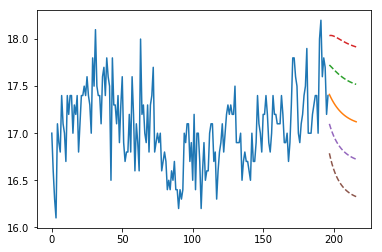

In [111]:
p = 1
q = 1
devs, means = arma_forecast(time_series_a, parama[0], parama[1], parama[-2], parama[-1])
plt.plot(time_series_a)
X = range(197, 197+len(means))

plt.plot(X, means)
plt.plot(X, means + devs, '--')
plt.plot(X, means + 2 * devs, '--')
plt.plot(X, means - devs, '--')
plt.plot(X, means - 2 * devs, '--')

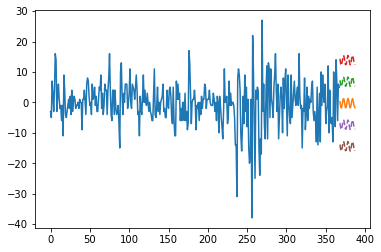

In [114]:
p = 3
q = 3
devs, means = arma_forecast(time_series_b, paramb[0], paramb[1], paramb[2], paramb[3])
plt.plot(time_series_b)
X = range(len(time_series_b), len(time_series_b)+len(means))

plt.plot(X, means)
plt.plot(X, means + devs, '--')
plt.plot(X, means + 2 * devs, '--')
plt.plot(X, means - devs, '--')
plt.plot(X, means - 2 * devs, '--')


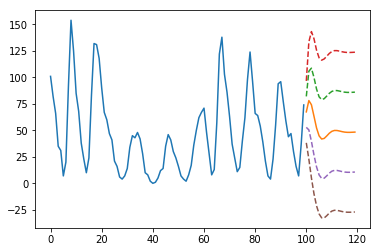

In [115]:
p = 2
q = 1
devs, means = arma_forecast(time_series_c, paramc[0], paramc[1], paramc[2], paramc[3])
plt.plot(time_series_c)
X = range(len(time_series_c), len(time_series_c)+len(means))

plt.plot(X, means)
plt.plot(X, means + devs, '--')
plt.plot(X, means + 2 * devs, '--')
plt.plot(X, means - devs, '--')
plt.plot(X, means - 2 * devs, '--')